In [16]:
#---------------------Import libraries --------------
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import os, pickle

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.gridding import WGS84_to_UTM

In [17]:
def create_buffer_poly(ISMN_station_file: str, grid_size: float, save: bool = True ) -> shapely.geometry.polygon.Polygon:

    # convert wgs geometry to projection system

    ISMN_station_loc_wgs84 = gpd.read_file(ISMN_station_file)
    ISMN_station_loc_wgs84.crs = "EPSG:4326"

    lon = ISMN_station_loc_wgs84['geometry'][0].x
    lat = ISMN_station_loc_wgs84['geometry'][0].y
    utm_crs_epsg = WGS84_to_UTM(lon, lat)    

    ISMN_station_loc_UTM = ISMN_station_loc_wgs84.to_crs(epsg=utm_crs_epsg).iloc[0].geometry

    ISMN_station_loc_UTM_buffer = ISMN_station_loc_UTM.buffer(grid_size, cap_style = 1)

    ISMN_station_loc_buffer = gpd.GeoDataFrame(index=[0], crs=utm_crs_epsg, geometry=[ISMN_station_loc_UTM_buffer])

    ISMN_station_loc_buffer = ISMN_station_loc_buffer.to_crs(epsg=4326)

    if save:
        save_dir = os.path.dirname(ISMN_station_file)
        filename = os.path.join(os.path.basename(ISMN_station_file).split('.')[0]+'_'+str(grid_size)+'.geojson')
        ISMN_station_loc_buffer.to_file(os.path.join(save_dir,filename), driver="GeoJSON")  

    return ISMN_station_loc_buffer.geometry

Calculate the FordDryLake_SM_data stack from scratch

In [21]:
ISMN_station = 'FordDryLake'
orbit_time_UTC = '14:00:00'
orbit_num = '173'
grid_size = 125

###############################################################################
# the name of your experiment
projectname = 'INSAR4SM_ISMN_rev_test_{}_sq{}_{}'.format(orbit_num, grid_size, ISMN_station)

# the directory of the topstack processing
topstackDir = '/RSL02/SM_NA/Topstack_processing_orbit_{}'.format(orbit_num)

# the AOI geojson file for your project
# ensure that AOI is inside your topstack stack
#AOI = '/RSL02/SM_NA/Plotting/bbox_aoi.geojson'
AOI = '/RSL02/SM_NA/ISMN/{}/{}_AOI.geojson'.format(ISMN_station,ISMN_station)

# the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
meteo_file = '/RSL02/SM_NA/era5/era5_land_na_orbit_{}.nc'.format(orbit_num)
# set to True in case you provide an ERA5-Land file
ERA5_flag = True
# In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
ERA5_sm_flag = True

# the output directory 
export_dir = '/RSL02/SM_NA/{}'.format(projectname)

# soil information datasets (https://soilgrids.org/)
sand_soilgrids = 87
clay_soilgrids = 13

# the insitu measurements in csv format
ISMN_csv = '/RSL02/SM_NA/ISMN/{}/ismn_station_{}.csv'.format(ISMN_station, ISMN_station)

# geometrical infromation regarding ISMN station

ISMN_station_loc = '/RSL02/SM_NA/ISMN/{}/{}_location.geojson'.format(ISMN_station,ISMN_station)


#IMSN_polygon = gpd.read_file('/RSL02/SM_NA/ISMN/{}/{}_neighborhood.geojson'.format(station_name, station_name))['geometry']

IMSN_polygon = create_buffer_poly(ISMN_station_loc, grid_size )

ISMN_point = IMSN_polygon.centroid

stack = INSAR4SM_stack(topstackDir = topstackDir,
                    projectname = projectname,
                    AOI = AOI,
                    meteo_file = meteo_file,
                    ERA5_flag = ERA5_flag,
                    sand = sand_soilgrids,
                    clay = clay_soilgrids,
                    orbit_time = orbit_time_UTC,
                    export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
stack.get_dry_SARs()
stack.calc_insar_stack()

stack.sm_points = ISMN_point
stack.sm_polygons = IMSN_polygon
stack.n_sm_points = len(stack.sm_points)

sm_point_ts = SM_point(stack, sm_ind=0)
sm_point_ts.get_DS_info(stack)
sm_point_ts.calc_covar_matrix()
sm_point_ts.get_DS_geometry(stack)

sm_point_ts.calc_driest_date()
#sm_point_ts.driest_date = pd.to_datetime(driest_date)
sm_point_ts.calc_sm_sorting()

# in_situ_data = pd.read_csv('/RSL02/SM_NA/comparison_FordDryLake.csv')
# print(in_situ_data['sm_plot'].loc[sm_point_ts.best_sorting])
sm_point_ts.calc_sm_coherence()
sm_point_ts.calc_sm_index()
sm_point_ts.inversion()
dict_clc_data = sm_point_ts.__dict__


number of SLCs discovered:  23
directory "/RSL02/SM_NA/INSAR4SM_ISMN_rev_test_173_sq125_FordDryLake/INSAR4SM_ISMN_rev_test_173_sq125_FordDryLake/INSAR4SM_datasets/slcs" already exists.
write vrt file for each SLC ...
stack directory: /RSL02/SM_NA/INSAR4SM_ISMN_rev_test_173_sq125_FordDryLake/INSAR4SM_ISMN_rev_test_173_sq125_FordDryLake/INSAR4SM_datasets/coreg_stack already exists
write vrt file for stack directory
directory /RSL02/SM_NA/INSAR4SM_ISMN_rev_test_173_sq125_FordDryLake/INSAR4SM_ISMN_rev_test_173_sq125_FordDryLake/INSAR4SM_datasets/geometry already exists.
write vrt file for geometry dataset


In [11]:
ISMN_data = '/RSL02/upload_github/InSAR4SM/testing/FordDryLake_data.pkl'
with open(ISMN_data, 'rb') as inp:
    FordDryLake_data = pickle.load(inp)

In [12]:
FordDryLake_SM_data = SM_point(insar4sm_stack = FordDryLake_data, sm_ind=0)
FordDryLake_SM_data.get_DS_info(FordDryLake_data)
FordDryLake_SM_data.calc_covar_matrix()
FordDryLake_SM_data.get_DS_geometry(FordDryLake_data)
FordDryLake_SM_data.calc_driest_date()
FordDryLake_SM_data.calc_sm_sorting()
FordDryLake_SM_data.calc_sm_coherence()
FordDryLake_SM_data.calc_sm_index()
FordDryLake_SM_data.inversion()
dict_data = FordDryLake_SM_data.__dict__

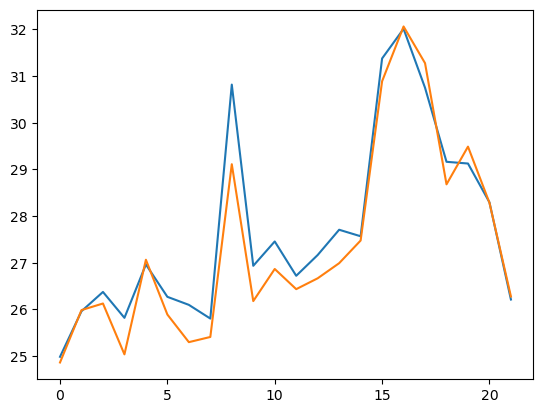

In [13]:
plt.plot(dict_clc_data['amp_DS'][0,:])
plt.plot(dict_data['amp_DS'][0,:])

[]

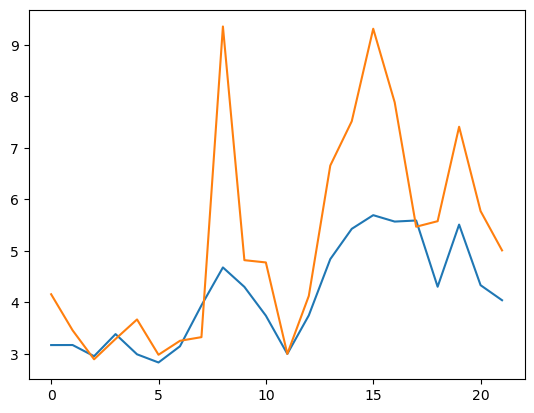

In [14]:
plt.plot(dict_clc_data['sm_inverted'])
plt.plot(dict_data['sm_inverted'])
plt.plot()

Text(0.5, 1.0, 'RMSE: 3.47 m3/m3')

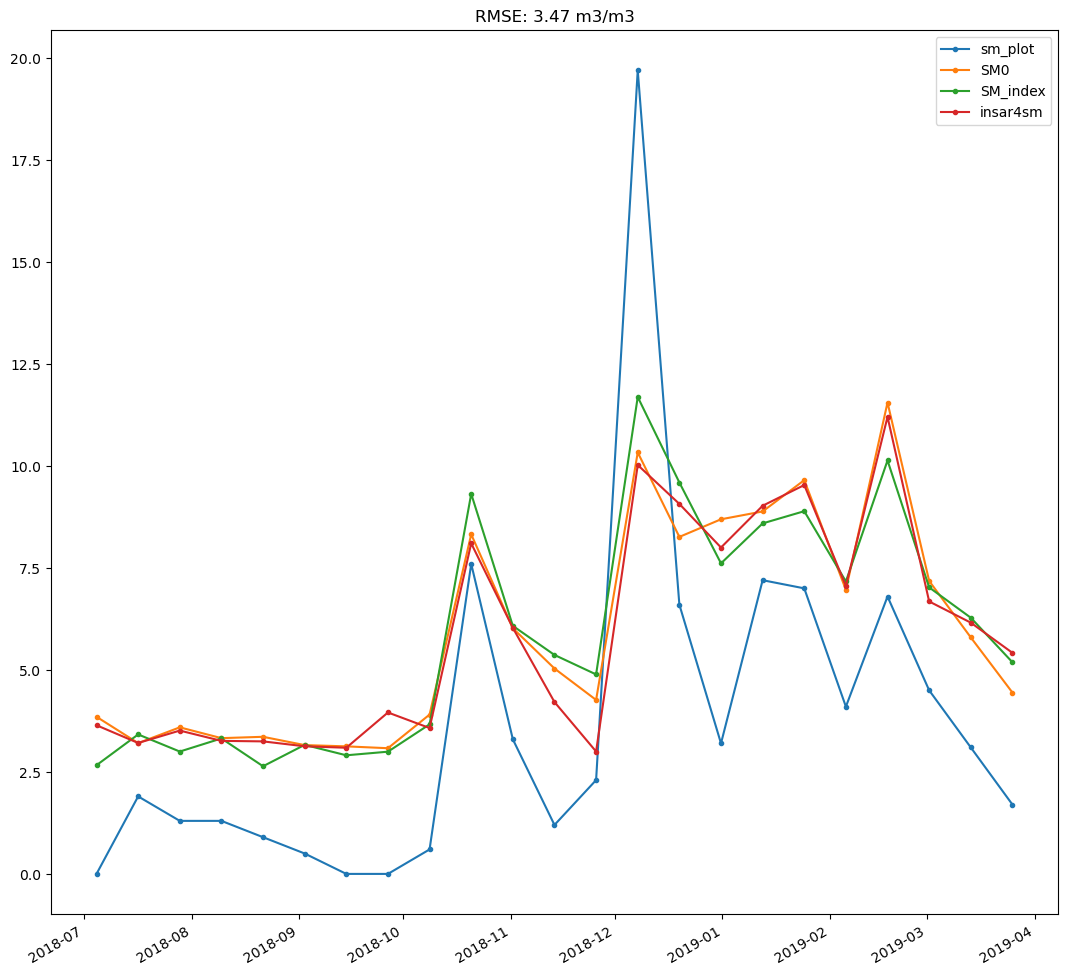

In [22]:
#sm_point = FordDryLake_SM_data

sm_point = sm_point_ts

IMSN_df = pd.read_csv(ISMN_csv)
IMSN_df.index = pd.to_datetime(IMSN_df['Datetime'])
IMSN_df = IMSN_df['sm_plot']
# select only particular hour

IMSN_df = IMSN_df.at_time(orbit_time_UTC).to_frame()

#insar4sm_df = pd.DataFrame(np.ones_like(sm_point_ts.best_sorting), columns=['insar4sm'])
sm_estimations = {'SM0':sm_point.SM0,
                'SM_index':sm_point.SM_index,
                'insar4sm':sm_point.sm_inverted
                }

insar4sm_df = pd.DataFrame(sm_estimations)
insar4sm_df.index = pd.to_datetime(stack.slc_datetimes)
insar4sm_df.index = insar4sm_df.index + pd.Timedelta('{} hour'.format(pd.to_datetime(orbit_time_UTC).hour))

comparison_df = IMSN_df.join(insar4sm_df, how='outer').dropna()
comparison_df['Datetime'] = comparison_df.index
comparison_df.to_csv('{}/comparison_{}.csv'.format(stack.export_dir,ISMN_station), index=False)

predictions = comparison_df['insar4sm'].values
targets = comparison_df['sm_plot'].values
n = predictions.shape[0]
rmse = np.linalg.norm(predictions - targets) / np.sqrt(n)

comparison_df[['sm_plot', 'SM0', 'SM_index', 'insar4sm']].plot(figsize=(13,13), style='.-')
plt.title('RMSE: {} m3/m3'.format(round(rmse,2)))